# LOGISTIC REGRESSION ON AMAZON FINE FOOD REVIEWS DATASET

Data Source **[https://www.kaggle.com/snap/amazon-fine-food-reviews](https://www.kaggle.com/snap/amazon-fine-food-reviews)**

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.It consist of data collected from past many years. This dataset consist of approx 550k reviews. 

![](https://cdn-images-1.medium.com/max/1600/1*CfV_EAgUO1zcRusrWhXIfg.jpeg)

## SNIPPET
1. Converted the reviews using NLP techniques i.e BOW, tf-IDF, Word2Vec and tf-IDF Word2Vec.
2. Applied Logistic Regression on the dataset with both CV techniques i.e GridSearchCV as well as RandomSearchCV. 
3. Calculated Train Error, CV Error and Test Error to determine the performance and to ensure best fit.
4. Compared performance of each model using accuracy, f1-score, recall, precision.
5. Made confusion matrix between predicted and tested data.
6. Shown the variation of Error & Sparsity with increse in lambda.
7. Performed Perturbation Testing.
6. Conclusion based on the obtained results.

## DATA INFORMATION
* Number of reviews: 568,454
* Number of users: 256,059
* Number of products: 74,258
* Timespan: Oct 1999 - Oct 2012
* Number of Attributes/Columns in data: 10 

## ATTRIBUTE INFORMATION

1.  Id
2.  ProductId - unique identifier for the product
3.  UserId - unqiue identifier for the user
4.  ProfileName
5.  HelpfulnessNumerator - number of users who found the review helpful
6.  HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7.  Score - rating between 1 and 5
8.  Time - timestamp for the review
9.  Summary - brief summary of the review
10. Text - text of the review

## OBJECTIVE
Predict the polarity of the review using Logistic Regression and Compare both CV techniques and regularizers i.e GridSearchCV & RandomSearchCV to find the best one and ensure that the model is neither overfitting nor underfitting. Moreover to check that the features are dependent or related to each other or not.   

## IMPORTING

In [3]:
import warnings
warnings.filterwarnings("ignore")
import re
import time
import gensim
import pickle
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import statistics as s
from scipy import sparse
from scipy.sparse import find
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

## LOADING

In [4]:
conn=sqlite3.connect('./final.sqlite') # making a connection with sqlite
Data=pd.read_sql_query("""SELECT * FROM Reviews""",conn)

In [5]:
Data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


## MAPPING

In [6]:
# function to map the polarity as 0 or 1
def sign(x):
    if x=='positive':
        return 1
    else:
        return 0

Data['Score']=Data['Score'].map(sign)

In [7]:
# Dimension
print(Data.shape)

(364171, 12)


In [8]:
Data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

## SORTING

In [9]:
# Sorting the data according to Time.
Data.sort_values('Time',inplace=True)

## FUNCTIONS

### Split Function

In [10]:
'''
This function is used to split that data into train and test.
It uses the function to split it into 70-30 %.
It does not shuffle so the data is distributed sequentially.
'''
def Split(d1,d2):
    a,b,c,d= train_test_split(d1,d2,test_size=0.3,shuffle=False) # Splitting it in 70-30 without shuffling.
    return a,b,c,d

### GridSearchCV & RandomizedSearchCV 

In [11]:
'''
This function takes training data and algorithm as input and gives execution time, accuracy and 
the optimal value of alpha
on that data.
It uses GridSearch CV.
'''
def LR(X,Y,s):
    tscv = TimeSeriesSplit(n_splits=10)
    tuned_parameters = {'C': [0.001, 0.01, 1, 10, 100, 1000], 'penalty':['l1','l2']}
    clf = LogisticRegression()
    if s=='Grid':
        start = time.time()
        model = GridSearchCV(clf, tuned_parameters, cv=tscv)
        model.fit(X,Y)
        end = time.time()
        t=end-start
        print("Time taken to complete -: ",t,"sec\n")
        print("Best Hyperparameter -: ",model.best_params_,"\n")
        print("Accuracy -: ",round(model.best_score_*100,3),"%")
        return model
    else:
        start = time.time()
        model = RandomizedSearchCV(clf, tuned_parameters, cv=tscv)
        model.fit(X,Y)
        end = time.time()
        t=end-start
        print("Time taken to complete -: ",t,"sec\n")
        print("Best Hyperparameter -: ",model.best_params_,"\n")
        print("Accuracy -: ",round(model.best_score_*100,3),"%")
        return model

### Hyperparameters vs Accuracy

In [12]:
'''
Calculates the accuracy on l1 & l2 regularizer and plot it against hyperparameters.
'''
def Accplot(h,nlp):
    l1=[]
    l2=[]
    j=0
    #print(h.cv_results_)
    acu = h.cv_results_['mean_test_score']
    alp = [0.001, 0.01, 1, 10, 100, 1000]
    for i in acu:
        if j%2==0:
            l1.append(i)
        else:
            l2.append(i)
        j+=1
    sns.set_style("darkgrid")
    plt.figure(figsize=(17,5))
    plt.figure(1)
    plt.subplot(121)    
    plt.plot(alp,l1,'b--')
    plt.xlabel("Hyperparameter",fontsize=15, color='black')
    plt.ylabel("Accuracy",fontsize=15, color='black')
    plt.title("Accuracy -" + nlp + " -l1 regularizer",fontsize=15, color='black')
    plt.subplot(122)
    plt.plot(alp,l2,'r--')
    plt.xlabel("Hyperparameter",fontsize=15, color='black')
    plt.ylabel("Accuracy",fontsize=15, color='black')
    plt.title("Accuracy -" + nlp + " -l2 regularizer",fontsize=15, color='black')
    plt.show()
    print("\n")
    print("Average Accuracy on l1 reg -: ",round(s.mean(l1),3)*100)
    print("Average Accuracy on l2 reg -: ",round(s.mean(l2),3)*100)

### Hyperparameter vs Error

In [13]:
'''
Calculates Error on both l1 regularizer as well as l2 regularizer and plots the train and Cv error against
hyperparameters for each l1 & l2.
'''
def Errorplot(h):
    
    l1_test = []
    l1_train = []
    l2_test = []
    l2_train = []
    j=0
    j1=0
    
    alp = [0.001, 0.01, 1, 10, 100, 1000]
    
    cv_acc = list(h.cv_results_['mean_test_score'])
    train_acc = list(h.cv_results_['mean_train_score'])
    
    a = [1 - x for x in cv_acc]
    b = [1 - x for x in train_acc]
    
    for i in a:
        if j%2==0:
            l1_test.append(i)
        else:
            l2_test.append(i)
        j+=1
        
    for k in b:
        if j1%2==0:
            l1_train.append(k)
        else:
            l2_train.append(k)
        j1+=1

        
    plt.figure(figsize=(17,5))
    plt.figure(1)
    plt.subplot(121)
    plt.plot(alp, l1_test, '-b', label='CV Error')
    plt.plot(alp, l1_train, '-r', label='Train Error')
    plt.legend(loc='upper right')
    plt.xlabel("Hyperparameters",fontsize=15, color='black')
    plt.ylabel("Train Error & Cv Error",fontsize=15, color='black')
    plt.title("Train vs CV Error on l1 regularizer" ,fontsize=15, color='black')
    plt.subplot(122)
    plt.plot(alp, l2_test, '-b', label='CV Error')
    plt.plot(alp, l2_train, '-r', label='Train Error')
    plt.legend(loc='upper right')
    plt.xlabel("Hyperparameters",fontsize=15, color='black')
    plt.ylabel("Train Error vs Cv Error",fontsize=15, color='black')
    plt.title("Train vs CV Error on l2 regularizer" ,fontsize=15, color='black')
    plt.show()
    
    x = PrettyTable()

    x.field_names = ["Regularizer", "CV Error", "Train Error"]

    x.add_row(["L1", round(s.mean(l1_test),3)*100, round(s.mean(l1_train),3)*100])
    x.add_row(["L2", round(s.mean(l2_test),3)*100, round(s.mean(l2_train),3)*100])
    
    print("\n")
    print(x)

###  Predicting On Best Hyperparameter

In [14]:
'''
It runs the desired algorithm on the optimal value of Alpha we get from training part.
It also returns predicted values.
'''

def predict(c,p,x_tr,y_tr,ts):
    clf = LogisticRegression(C = c, penalty = p)
    clf.fit(x_tr, y_tr)
    pred=clf.predict(ts)
    return clf,pred

### Performance Measurement

In [15]:
'''
It gives the performance in terms of accuracy, F1 Score, recall, precision and test error also.
It gives confusion matrix between actual and predicted values.
'''
def Measure(test,pre):
    print("Accuracy on Test Data -: ",round(((accuracy_score(test,pre))*100),3),"% \n")
    print("F1 Score -:  ",round(((f1_score(test,pre))),3),"\n")
    print("Precision Score -: ",round(((precision_score(test,pre))),3),"\n")
    print("Recall Score -: ",round((recall_score(test,pre)),3),"\n")
    print("Test Error -: ",100-round(((accuracy_score(test,pre))*100),3))
    cf = confusion_matrix(test,pre)
    df =pd.DataFrame(cf,index=[0,1],columns=[0,1])
    sns.set(font_scale=1.5)
    sns.heatmap(df,annot=True,annot_kws={"size" :20},fmt='g')
    return plt.show()

### Sparsity & Error with l1 Regularizer

In [16]:
'''
It takes hyperparameter values and regularizer and train & test datasets.
It returns error and sparsity.
'''
def Spar(c,x_tr,y_tr,x_ts,y_ts):
    clf = LogisticRegression(C = c, penalty = 'l1')
    clf.fit(x_tr, y_tr)
    pred=clf.predict(x_ts)
    print("\nFOR C = ",c)
    print("Error -: ",100-(round(((accuracy_score(y_ts,pred))*100),3)),"%")
    print("Sparsity -: ",np.count_nonzero(clf.coef_),"\n")
    print("_______________________________")

### MultiCollinearity Check

In [17]:
'''
This function checks multicollinearity or the realtion between the features.
'''
# _____________________________ Reference From StackOverflow __________________________________________________

def muc(c, p, cnt, x_tr, y_tr, x_ts, y_ts):
    clf = LogisticRegression(C = c, penalty = p)
    clf.fit(x_tr, y_tr)
    pred=clf.predict(x_ts)
    print("__________________________ Without Adding Weights _____________________________")
    print("Accuracy -: ",round(((accuracy_score(y_ts,pred))*100),3),"%")
    print("Sparsity -: ",np.count_nonzero(clf.coef_),"\n")
    w1=find(clf.coef_[0])[2]
    print("__________________________ Weights Before Adding Noise _____________________________")
    print(w1[20:40])
    x_tr_t = x_tr
    s = find(x_tr_t)[0].size
    noise = np.random.uniform(low = -0.0001, high=0.0001, size=s)
    i,j,k = find(x_tr_t)
    x_tr_t[i,j] = noise + x_tr_t[i,j]
    clf = LogisticRegression(C = c, penalty = p)
    clf.fit(x_tr_t, y_tr)
    pred=clf.predict(x_ts)
    print("__________________________ After Adding Weights _____________________________")
    print("Accuracy -: ",round(((accuracy_score(y_ts,pred))*100),3),"%")
    print("Sparsity -: ",np.count_nonzero(clf.coef_),"\n")
    w2=find(clf.coef_[0])[2]
    print("__________________________ Weights After Adding Noise _____________________________")
    print(w2[20:40])
    w_diff = (abs(w1-w2)/w1)*100
    
    # I have varied the percentage for different models.
    
    f = w_diff[np.where(w_diff > 25)].size
    print("\n")
    print("The no. of features which are changing greater than 25% - : ",f)
    print("\n")
    if f>0:
        print("Therefore, Approx. ",f,"features are multicollinear")
        IF(clf,cnt)
    else:
        print("Therefore, the features are not multicollinear")
        print("\n")

### Important Features

In [18]:
'''
This functions draws a pretty table of important features according to the Weights.
'''
def IF(c,co):
    a = c.coef_[0]
    f = co.get_feature_names()
    l1 = list(zip(a,f))
    l1 = sorted(l1,reverse=True)
    x = PrettyTable()
    x.field_names = ["Rank","Most Important Features", "Weight"]
    for i in range(25):
        x.add_row([i+1,l1[i][1],l1[i][0]])
    print(x)

### Using Pickle

In [19]:
'''
These functions are used to save and retrieve the information and use it afterwards for future reference.
'''

# Method to Save the data.
def save(o,f):
    op=open(f+".p","wb")
    pickle.dump(o,op)

# Method to retrieve the data.    
def retrieve(f):
    op=open(f+".p","rb")
    ret=pickle.load(op)
    return ret

# LOGISTIC REGRESSION MODEL ON BAG OF WORDS ( BOW )

![](https://cdn-images-1.medium.com/max/1600/0*JpqZhCNsQ_OGaRkB.jpg)

###  SPLITTING INTO TRAIN AND TEST

In [20]:
x_train, x_test, y_train, y_test = Split(Data['CleanedText'].values,Data['Score'].values)

###  CONVERTING REVIEWS INTO VECTORS USING BOW

In [21]:
count = CountVectorizer(ngram_range=(1,2)) 
x_train = count.fit_transform(x_train)
x_test = count.transform(x_test)

In [22]:
print("Train Dataset Shape -: ",x_train.shape)
print("Test Dataset Shape -: ",x_test.shape)

Train Dataset Shape -:  (254919, 2290079)
Test Dataset Shape -:  (109252, 2290079)


###   NORMALIZING THE DATA 

In [23]:
x_train = preprocessing.normalize(x_train)
x_test = preprocessing.normalize(x_test)

## GridSearchCV
![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRjNC188MQrvNa5yxmvL3siLiD5zmW7gZ4Rjkh0kVkmEk_m5CaO)

### HyperParameter Tuning

In [24]:
m = LR(x_train,y_train,'Grid')

Time taken to complete -:  2177.167261123657 sec

Best Hyperparameter -:  {'C': 1000, 'penalty': 'l2'} 

Accuracy -:  93.636 %


### Hyperparameter vs Accuracy plot

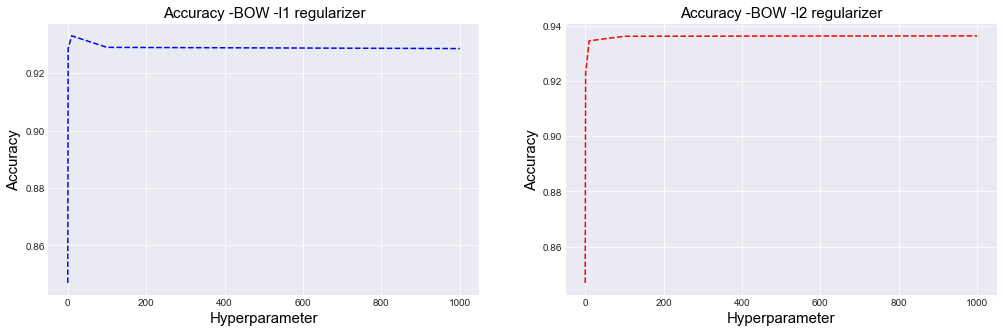



Average Accuracy on l1 reg -:  90.3
Average Accuracy on l2 reg -:  90.5


In [25]:
Accplot(m,"BOW")

### Hyperparameter vs Error Plot

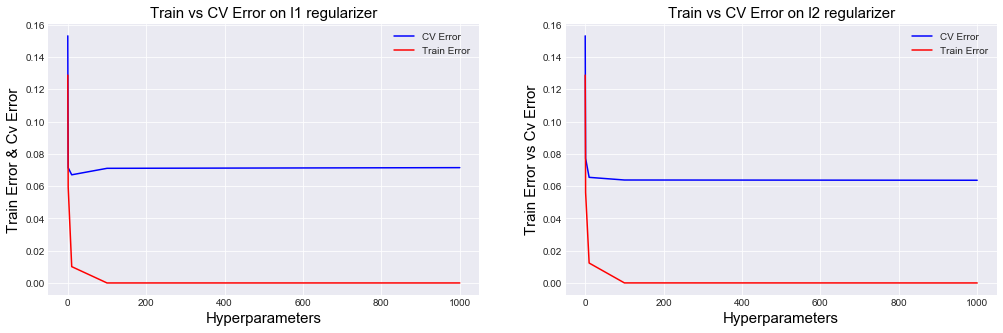



+-------------+----------+-------------+
| Regularizer | CV Error | Train Error |
+-------------+----------+-------------+
|      L1     |   9.7    |     5.4     |
|      L2     |   9.5    |     5.4     |
+-------------+----------+-------------+


In [26]:
Errorplot(m)

### Predicting on best Hyperparameter

In [27]:
cl, pr = predict(1000,'l2',x_train,y_train,x_test)

### Performance Measurement

Accuracy on Test Data -:  93.845 % 

F1 Score -:   0.963 

Precision Score -:  0.952 

Recall Score -:  0.974 

Test Error -:  6.155


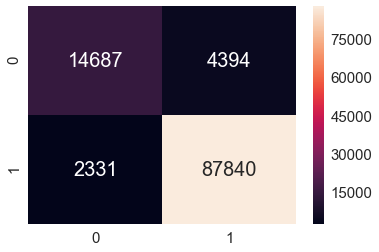

In [28]:
Measure(y_test,pr)

In [32]:
a = cl.coef_[0]
f = count.get_feature_names()
l1 = list(zip(a,f))
l1 = sorted(l1,reverse=True)

In [38]:
l1[-20:]

[(-25.883348345840144, 'not tasti'),
 (-25.891359873880209, 'yuck'),
 (-25.898838073558434, 'wont purchas'),
 (-26.329171598491815, 'doesnt work'),
 (-26.874831766263636, 'terribl'),
 (-26.901526622925619, 'usual love'),
 (-27.813162528264577, 'way sweet'),
 (-27.837595254493269, 'wont buy'),
 (-28.04351233862851, 'aw'),
 (-28.872960249451172, 'not happi'),
 (-28.95479667014472, 'great review'),
 (-29.799316445412433, 'want like'),
 (-30.350550454245976, 'dont recommend'),
 (-30.674006309413187, 'least favorit'),
 (-31.91710636046275, 'undrink'),
 (-33.288268926447778, 'not recommend'),
 (-33.429113326764075, 'not impress'),
 (-39.521216369602215, 'worst'),
 (-39.933434041050688, 'not worth'),
 (-58.281892490084317, 'two star')]

In [39]:
count1=count

In [42]:
l = count1.get_feature_names()
type(l)

list

In [44]:
print(l[0:20])

['aa', 'aa pleas', 'aa state', 'aaa', 'aaa aaa', 'aaa condit', 'aaa dont', 'aaa hockey', 'aaa magazin', 'aaa perfect', 'aaa plus', 'aaa spelt', 'aaa tue', 'aaaa', 'aaaaa', 'aaaaa kid', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa serious', 'aaaaaaaaaaaaaaaaaaaargh', 'aaaaaaaaaaaaaaaaaaaargh wait']


In [46]:
for i in range(len(l)):
    l[i] = l[i].replace(" ","_")

In [47]:
print(l[0:20])

['aa', 'aa_pleas', 'aa_state', 'aaa', 'aaa_aaa', 'aaa_condit', 'aaa_dont', 'aaa_hockey', 'aaa_magazin', 'aaa_perfect', 'aaa_plus', 'aaa_spelt', 'aaa_tue', 'aaaa', 'aaaaa', 'aaaaa_kid', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa_serious', 'aaaaaaaaaaaaaaaaaaaargh', 'aaaaaaaaaaaaaaaaaaaargh_wait']


In [ ]:
pos=0
neg=0
for i in a:
    if i>0:
        pos+=1
    else:
        neg+=1

In [ ]:
print(pos)
print(neg)

## RandomSearchCV

### HyperParameter Tuning

In [28]:
m = LR(x_train,y_train,'Random')

Time taken to complete -:  1940.7424070835114 sec

Best Hyperparameter -:  {'penalty': 'l2', 'C': 1000} 

Accuracy -:  93.636 %


### Predict on Best Hyperparameter

In [110]:
cl, pr = predict(1000,'l2',x_train,y_train,x_test)

### Performance Measurement

Accuracy on Test Data -:  93.845 % 

F1 Score -:   0.963 

Precision Score -:  0.952 

Recall Score -:  0.974 

Test Error -:  6.155


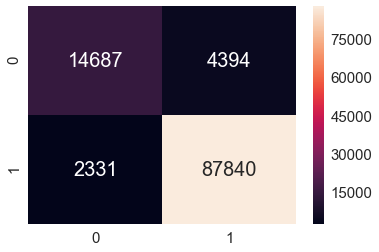

In [111]:
Measure(y_test,pr)

## Perturbation Testing & Most Important Features

In [158]:
muc(100,'l2',count,x_train,y_train,x_test,y_test)

__________________________ Without Adding Weights _____________________________
Accuracy -:  93.848 %
Sparsity -:  2290079 

__________________________ Weights Before Adding Noise _____________________________
[ 0.03148651  0.00073087  0.00072889 -0.1176949  -0.11682553  0.00047818
  0.00047912  0.02590252  0.02576515  0.02625819  0.02636826 -0.10202166
 -0.10270304  0.00065026  0.00065027  0.00073295  0.00073478  0.02104627
  0.00343749  0.01751685]
__________________________ After Adding Weights _____________________________
Accuracy -:  93.849 %
Sparsity -:  2290079 

__________________________ Weights After Adding Noise _____________________________
[ 0.03170446  0.0008444   0.00084155 -0.11819555 -0.11710487  0.00056001
  0.0005614   0.02579992  0.02562869  0.02624327  0.02638048 -0.10160746
 -0.10245528  0.00073456  0.00073458  0.00084741  0.00085006  0.02157005
  0.00357672  0.01787577]


The no. of features which are changing greater than 45% - :  1058
Therefore, the features a

## LOGISTIC REGRESSION MODEL ON tf-IDF

![](https://lphinternetservices.com/images/TF-IDF-define.jpg)

###  SPLITTING INTO TRAIN AND TEST

In [159]:
x_train, x_test, y_train, y_test = Split(Data['CleanedText'].values,Data['Score'].values)

###  CONVERTING REVIEWS INTO VECTORS USING tf-IDF

In [160]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2)) 
x_train = tf_idf_vect.fit_transform(x_train)
x_test = tf_idf_vect.transform(x_test)

In [161]:
print("Train Dataset Shape -: ",x_train.shape)
print("Test Dataset Shape -: ",x_test.shape)

Train Dataset Shape -:  (254919, 2290079)
Test Dataset Shape -:  (109252, 2290079)


###   NORMALIZING THE DATA 

In [162]:
x_train = preprocessing.normalize(x_train)
x_test = preprocessing.normalize(x_test)

## GridSearchCV

### HyperParameter Tuning

In [164]:
m = LR(x_train,y_train,'Grid')

Time taken to complete -:  1353.2826647758484 sec

Best Hyperparameter -:  {'C': 1000, 'penalty': 'l2'} 

Accuracy -:  93.429 %


### Hyperparameter vs Accuracy plot

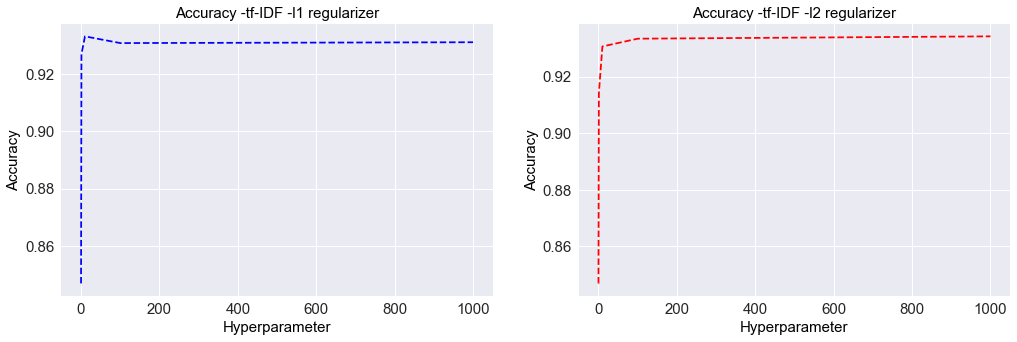



Average Accuracy on l1 reg -:  90.3
Average Accuracy on l2 reg -:  90.1


In [167]:
Accplot(m,"tf-IDF")

### Hyperparameter vs Error Plot

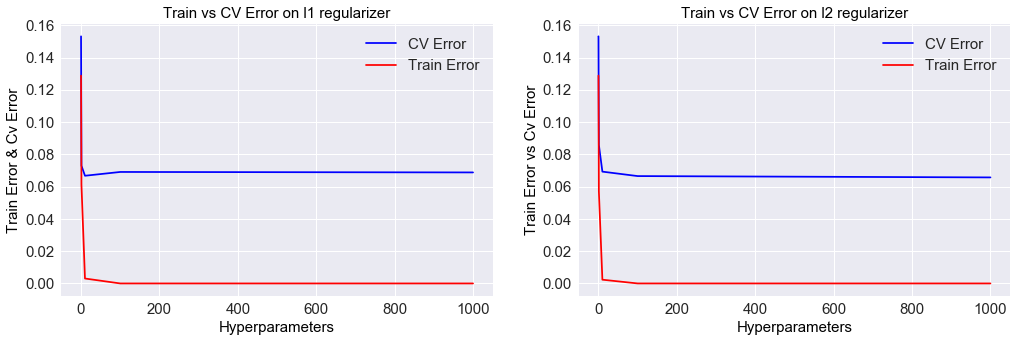



+-------------+----------+-------------+
| Regularizer | CV Error | Train Error |
+-------------+----------+-------------+
|      L1     |   9.7    |     5.4     |
|      L2     |   9.9    |     5.3     |
+-------------+----------+-------------+


In [168]:
Errorplot(m)

### Predicting on best Hyperparameter

In [169]:
cl, pr = predict(1000,'l2',x_train,y_train,x_test)

### Performance Measurement

Accuracy on Test Data -:  93.898 % 

F1 Score -:   0.964 

Precision Score -:  0.951 

Recall Score -:  0.976 

Test Error -:  6.102


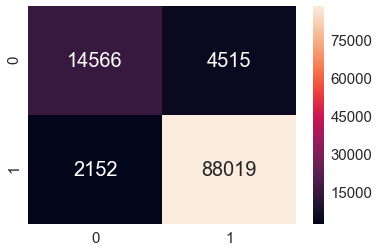

In [170]:
Measure(y_test,pr)

## RandomSearchCV

### HyperParameter Tuning

In [171]:
m = LR(x_train,y_train,'Random')

Time taken to complete -:  1148.8976826667786 sec

Best Hyperparameter -:  {'penalty': 'l2', 'C': 1000} 

Accuracy -:  93.429 %


### Predicting on best Hyperparameter

In [172]:
cl, pr = predict(1000,'l2',x_train,y_train,x_test)

### Performance Measurement

Accuracy on Test Data -:  93.898 % 

F1 Score -:   0.964 

Precision Score -:  0.951 

Recall Score -:  0.976 

Test Error -:  6.102


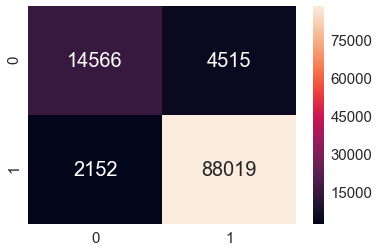

In [173]:
Measure(y_test,pr)

## Perturbation Testing & Most Important Features

In [175]:
muc(1000,'l2',count,x_train,y_train,x_test,y_test)

__________________________ Without Adding Weights _____________________________
Accuracy -:  93.898 %
Sparsity -:  2290079 

__________________________ Weights Before Adding Noise _____________________________
[ 0.02002966  0.00899722  0.00899722 -0.29669962 -0.29669962  0.00782466
  0.00782466  0.04067399  0.04067399  0.04067399  0.04067399 -0.19896223
 -0.19896223  0.00381418  0.00381418  0.00899722  0.00899722  0.07032526
  0.01165108  0.06098302]
__________________________ After Adding Weights _____________________________
Accuracy -:  93.897 %
Sparsity -:  2290079 

__________________________ Weights After Adding Noise _____________________________
[ 0.02012778  0.00900098  0.00899655 -0.29713966 -0.29679242  0.00784464
  0.00784732  0.04045345  0.04041887  0.04054299  0.0405707  -0.19917217
 -0.19940993  0.00381575  0.00381577  0.00900565  0.00900977  0.07056717
  0.01166215  0.06116929]


The no. of features which are changing greater than 45% - :  224
Therefore, the features ar

## LOGISTIC REGRESSION MODEL ON Avg Word2Vec

![](https://adriancolyer.files.wordpress.com/2016/04/word2vec-gender-relation.png?w=596)

## Loading Data From File

In [244]:
x_train = retrieve("Word2Vec-Train")
x_test = retrieve("Word2Vec-Test")

In [245]:
print("Train Dataset Shape -: ",x_train.shape)
print("Test Dataset Shape -: ",x_test.shape)

Train Dataset Shape -:  (254919, 100)
Test Dataset Shape -:  (109252, 100)


In [246]:
x_train = preprocessing.normalize(x_train)
x_test = preprocessing.normalize(x_test)

## GridSearchCV

### HyperParameter Tuning

In [183]:
m = LR(x_train,y_train,'Grid')

Time taken to complete -:  1866.907469034195 sec

Best Hyperparameter -:  {'C': 10, 'penalty': 'l1'} 

Accuracy -:  90.613 %


### Hyperparameter vs Accuracy plot

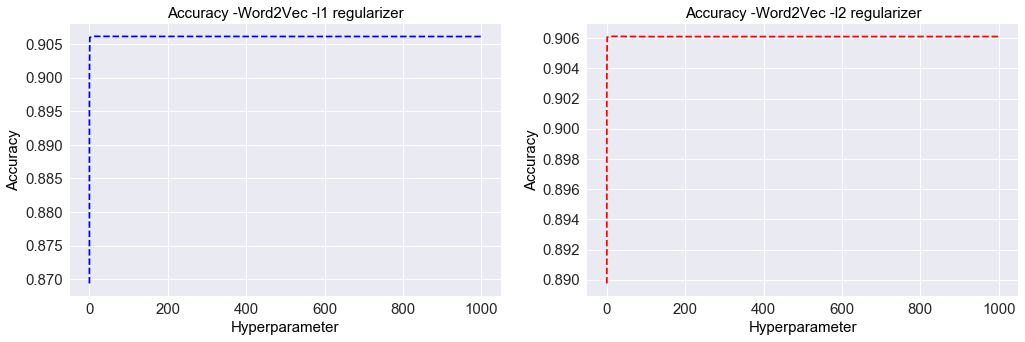



Average Accuracy on l1 reg -:  89.9
Average Accuracy on l2 reg -:  90.3


In [184]:
Accplot(m,"Word2Vec")

### Hyperparameter vs Error Plot

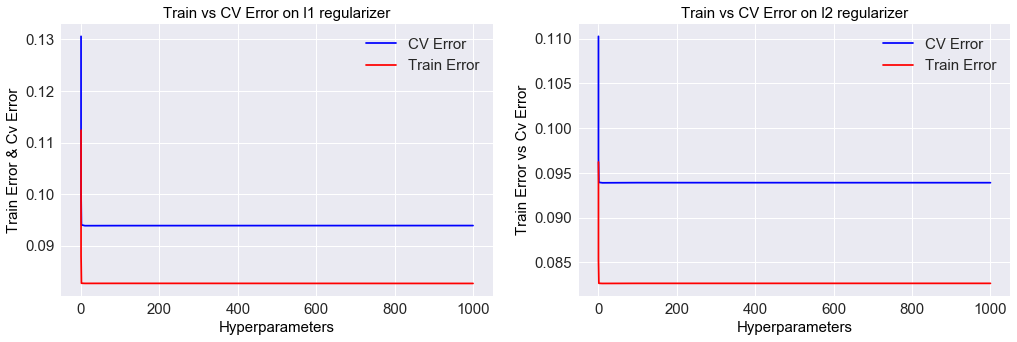



+-------------+----------+-------------+
| Regularizer | CV Error | Train Error |
+-------------+----------+-------------+
|      L1     |   10.1   |     8.9     |
|      L2     |   9.7    |     8.5     |
+-------------+----------+-------------+


In [185]:
Errorplot(m)

### Predicting on best Hyperparameter

In [186]:
cl, pr = predict(10,'l1',x_train,y_train,x_test)

### Performance Measurement

Accuracy on Test Data -:  89.951 % 

F1 Score -:   0.941 

Precision Score -:  0.916 

Recall Score -:  0.967 

Test Error -:  10.049


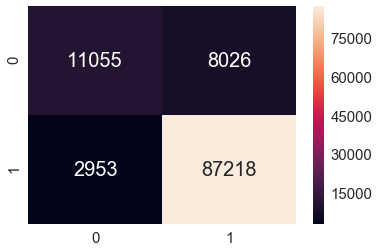

In [187]:
Measure(y_test,pr)

## RandomSearchCV

### HyperParameter Tuning

In [191]:
m = LR(x_train,y_train,'Random')

Time taken to complete -:  1255.9150743484497 sec

Best Hyperparameter -:  {'penalty': 'l1', 'C': 100} 

Accuracy -:  90.613 %


### Predicting on best Hyperparameter

In [192]:
cl, pr = predict(100,'l1',x_train,y_train,x_test)

### Performance Measurement

Accuracy on Test Data -:  89.952 % 

F1 Score -:   0.941 

Precision Score -:  0.916 

Recall Score -:  0.967 

Test Error -:  10.048


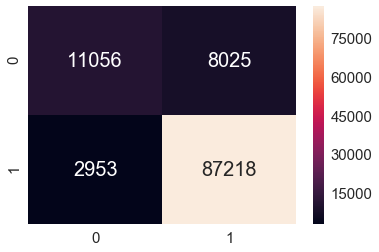

In [193]:
Measure(y_test,pr)

## Perturbation Testing & Most Important Features

In [248]:
muc(10,'l1',count,x_train,y_train,x_test,y_test)

__________________________ Without Adding Weights _____________________________
Accuracy -:  90.079 %
Sparsity -:  100 

__________________________ Weights Before Adding Noise _____________________________
[-0.65328423  4.30807754  2.75024395  0.7504924   4.66648608 -3.91403971
  3.1598497   3.63224149  1.50035848  1.32009116  1.31141728 -3.84303892
 -1.06954065 -1.85355511  0.66127268  1.84013293  2.6620992   4.33684717
  0.58927849 -1.80202248]
__________________________ After Adding Weights _____________________________
Accuracy -:  90.079 %
Sparsity -:  100 

__________________________ Weights After Adding Noise _____________________________
[-0.65264396  4.30672336  2.75060328  0.75085858  4.66567812 -3.91399743
  3.16143489  3.63322853  1.50077616  1.32082567  1.31192407 -3.84329915
 -1.07015799 -1.85242117  0.66271248  1.84079513  2.66226709  4.33954868
  0.58822809 -1.80177214]


The no. of features which are changing greater than 40% - :  0
Therefore, the features are not mult

## LOGISTIC REGRESSION MODEL ON tf-IDF Word2Vec

### LOADING DATA FROM FILE

In [195]:
x_train = retrieve("tfidf-W2v-train")
x_test = retrieve("tf-idf-w2v-test")

In [196]:
print("Train Dataset Shape -: ",x_train.shape)
print("Test Dataset Shape -: ",x_test.shape)

Train Dataset Shape -:  (254919, 100)
Test Dataset Shape -:  (109252, 100)


In [198]:
# Creating new dataframes and putting array values in it.
train_d = pd.DataFrame(x_train)
test_d = pd.DataFrame(x_test)

In [199]:
'''
replacing Nan values with constant in whole dataframes.
'''
x_train = train_d.fillna(0)
x_test = test_d.fillna(0)

In [200]:
print(train_d.shape)
print(test_d.shape)

(254919, 100)
(109252, 100)


In [203]:
# Saving for future assignments.
save(x_train,"tfidf_w2v_train")
save(x_test,"tfidf_w2v_test")

### Normalizing the Data

In [204]:
x_train = preprocessing.normalize(x_train)
x_test = preprocessing.normalize(x_test)

## GridSearchCV

### HyperParameter Tuning

In [205]:
m = LR(x_train,y_train,'Grid')

Time taken to complete -:  834.3468735218048 sec

Best Hyperparameter -:  {'C': 10, 'penalty': 'l2'} 

Accuracy -:  89.185 %


### Hyperparameter vs Accuracy plot

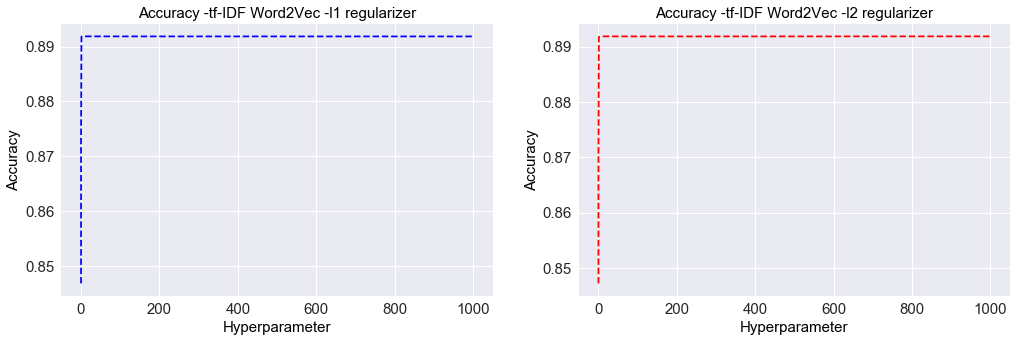



Average Accuracy on l1 reg -:  88.1
Average Accuracy on l2 reg -:  88.1


In [206]:
Accplot(m,"tf-IDF Word2Vec")

### Hyperparameter vs Error Plot

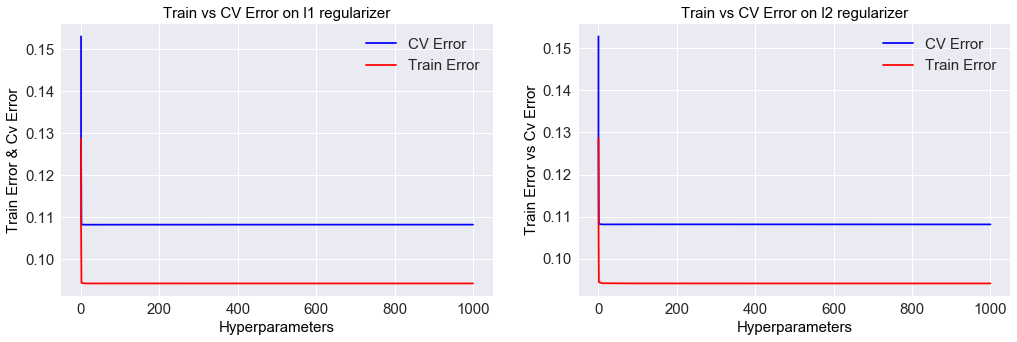



+-------------+----------+-------------+
| Regularizer | CV Error | Train Error |
+-------------+----------+-------------+
|      L1     |   11.9   |     10.2    |
|      L2     |   11.9   |     10.3    |
+-------------+----------+-------------+


In [207]:
Errorplot(m)

### Predicting on best Hyperparameter

In [208]:
cl, pr = predict(10,'l2',x_train,y_train,x_test)

### Performance Measurement

Accuracy on Test Data -:  88.213 % 

F1 Score -:   0.931 

Precision Score -:  0.898 

Recall Score -:  0.967 

Test Error -:  11.787


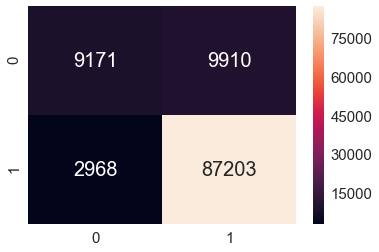

In [209]:
Measure(y_test,pr)

## RandomSearchCV

### HyperParameter Tuning

In [210]:
m = LR(x_train,y_train,'Random')

Time taken to complete -:  703.25212931633 sec

Best Hyperparameter -:  {'penalty': 'l2', 'C': 1000} 

Accuracy -:  89.185 %


### Predicting on best Hyperparameter

In [211]:
cl, pr = predict(1000,'l2',x_train,y_train,x_test)

### Performance Measurement

Accuracy on Test Data -:  88.207 % 

F1 Score -:   0.931 

Precision Score -:  0.898 

Recall Score -:  0.967 

Test Error -:  11.793


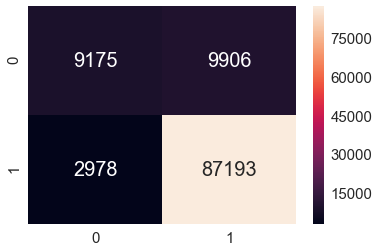

In [212]:
Measure(y_test,pr)

## Perturbation Testing & Most Important Features

In [226]:
muc(10,'l2',count,x_train,y_train,x_test,y_test)

__________________________ Without Adding Weights _____________________________
Accuracy -:  88.213 %
Sparsity -:  100 

__________________________ Weights Before Adding Noise _____________________________
[-1.50491463  4.12457625  1.8145111   0.56468903  3.62400594 -4.05997015
  2.65292544  3.88932183  1.40524758  0.49444092  0.94394901 -3.21870626
 -0.45658308 -1.37685048  0.62665631  1.22169452  2.13516832  3.15228367
 -0.42686414 -1.3344293 ]
__________________________ After Adding Weights _____________________________
Accuracy -:  88.213 %
Sparsity -:  100 

__________________________ Weights After Adding Noise _____________________________
[-1.50395916  4.12481309  1.81556218  0.56452883  3.62891696 -4.06088593
  2.65063101  3.88818585  1.40405688  0.49288106  0.94383467 -3.21946672
 -0.4590658  -1.37541519  0.62872374  1.21931655  2.13589464  3.15593736
 -0.42699785 -1.33466254]


The no. of features which are changing greater than 15% - :  0
Therefore, the features are not mult

## ANALYZING ERROR & SPARSITY

In [242]:
Spar(100,x_train,y_train,x_test,y_test)
Spar(10,x_train,y_train,x_test,y_test)
Spar(1,x_train,y_train,x_test,y_test)
Spar(0.1,x_train,y_train,x_test,y_test)
Spar(0.01,x_train,y_train,x_test,y_test)


FOR C =  100
Error -:  11.789 %
Sparsity -:  100 

_______________________________

FOR C =  10
Error -:  11.789 %
Sparsity -:  100 

_______________________________

FOR C =  1
Error -:  11.799 %
Sparsity -:  100 

_______________________________

FOR C =  0.1
Error -:  11.873 %
Sparsity -:  98 

_______________________________

FOR C =  0.01
Error -:  12.656 %
Sparsity -:  58 

_______________________________


#### As we can analyze above that as the c value decreases error increases and sparsity also decreases.

![](https://hibrp001.files.wordpress.com/2017/10/qc-1269.jpeg?w=740)

In [230]:
x = PrettyTable()

x.field_names = ["NLP Technique", "CV", "Hyperparameter", "Regularizer", "Accuracy(%)"]

x.add_row(["BOW", "GridSearchCV", 100, "l2", 93.721])
x.add_row(["BOW", "RandomSearchCV", 1000, "l2", 93.845])
x.add_row(["tf-IDF", "GridSearchCV", 1000,"l2", 93.898])
x.add_row(["tf-IDF", "RandomSearchCV", 1000,"l2", 93.898])
x.add_row(["Avg Word2Vec", "GridSearchCV", 10,"l2",89.951])
x.add_row(["Avg Word2Vec", "RandomSearchCV",100,"l1",89.952 ])
x.add_row(["tf-IDF Word2Vec", "GridSearchCV", 10,"l2",88.213])
x.add_row(["tf-IDF Word2Vec", "RandomSearchCV",1000,"l2",88.207])

print(x)

+-----------------+----------------+----------------+-------------+-------------+
|  NLP Technique  |       CV       | Hyperparameter | Regularizer | Accuracy(%) |
+-----------------+----------------+----------------+-------------+-------------+
|       BOW       |  GridSearchCV  |      100       |      l2     |    93.721   |
|       BOW       | RandomSearchCV |      1000      |      l2     |    93.845   |
|      tf-IDF     |  GridSearchCV  |      1000      |      l2     |    93.898   |
|      tf-IDF     | RandomSearchCV |      1000      |      l2     |    93.898   |
|   Avg Word2Vec  |  GridSearchCV  |       10       |      l2     |    89.951   |
|   Avg Word2Vec  | RandomSearchCV |      100       |      l1     |    89.952   |
| tf-IDF Word2Vec |  GridSearchCV  |       10       |      l2     |    88.213   |
| tf-IDF Word2Vec | RandomSearchCV |      1000      |      l2     |    88.207   |
+-----------------+----------------+----------------+-------------+-------------+


![](https://clip2art.com/images/professional-clipart-conclusion-18.jpg)

### 1. The comparison shows that tf-IDF is a good technique on Logistic Regression for this dataset with an accuracy of 93.898 %.
### 2. Therefore the best hyperparameter is 1000 with an F1 Score of 0.964, recall Score of 0.976 and a precision of 0.951
### 3. RandomSearchCV is giving better results as compared to GridSearchCV.
### 4. We can analyze that features in BOW and tf-IDF are changing massively therefore they are multicollinear but the features in Word2Vec are not changing at that extent.
### 5. As C decreases the sparsity also decreases but error increases.
### 6. Logistic Regression is better than Knn and Naive Bayes on this dataset as it is giving better accuracy.